In [85]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import torch
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import math
import plotly.graph_objects as go

In [86]:
import os
import sys

nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

In [87]:
from core.time_series_clustering import KmeansClustering
from core.data_preparation import DataPreparation


In [88]:
from core.curve_fit import fit_polynomial_curve_to_data_and_visualize

Load and Prepare data to input to LSTM model

In [89]:
filepath = "../Data/Google_2005-2022.csv"
data = pd.read_csv(filepath)
data = data.sort_values('Date')
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2005-01-03,98.331429,101.439781,97.365051,100.976517,100.976517,31807176
1,2005-01-04,100.323959,101.086105,96.378746,96.886841,96.886841,27614921
2,2005-01-05,96.363808,98.082359,95.756081,96.393692,96.393692,16534946
3,2005-01-06,97.175758,97.584229,93.509506,93.922951,93.922951,20852067
4,2005-01-07,94.964050,96.762314,94.037521,96.563057,96.563057,19398238


In [90]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(device)

cuda


In [91]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=data.index, y=data['Close'], mode='lines', name='closing price'))


In [92]:
window_size = 50
prep = DataPreparation(window_size=50)
scaler = MinMaxScaler(feature_range=(-1, 1))

In [93]:
scaler, x_train, x_test, y_train_lstm, y_test_lstm = prep.normalize_and_prepare_data(data['Close'].values, scaler)

x_train.shape =  (3390, 50, 1)
y_train.shape =  (3390, 1)
x_test.shape =  (810, 50, 1)
y_test.shape =  (810, 1)


In [94]:
num_clusters = 5

In [95]:
kmeans = KmeansClustering(num_clusters)
kmeans.compute_clusters(x_train)

DBA k-means


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


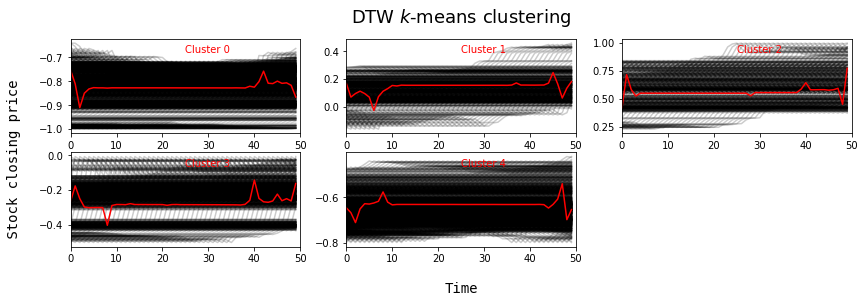

In [96]:
kmeans.visualize_clustering_results()

In [97]:
y_train = y_train_lstm.flatten().numpy()

In [98]:
type(y_train)

numpy.ndarray

In [99]:
train_errors = pd.read_csv('Google_ErrorDistribution.csv', usecols=[2])
train_errors.head()

,diff
0,21.144577
1,18.875854
2,18.372643
3,17.953827
4,19.183685


In [100]:
clusters = []
for i in range(num_clusters):

    clusters.append(scaler.inverse_transform(kmeans.cluster_centers_[i].flatten().reshape(-1,1)))

In [101]:
# y2 = scaler.inverse_transform(kmeans.cluster_centers_[2].flatten().reshape(-1,1))
# y2

In [102]:
# clusters[2]

In [103]:
kmeans.cluster_centers_[2].flatten()

array([0.42171948, 0.71841785, 0.58563024, 0.52708697, 0.55196552,
       0.55196647, 0.55196647, 0.55196647, 0.55196647, 0.55196647,
       0.55196647, 0.55196647, 0.55196647, 0.55196647, 0.55196647,
       0.55196647, 0.55196647, 0.55196647, 0.55196647, 0.55196647,
       0.55196647, 0.55196647, 0.55196647, 0.55196647, 0.55196647,
       0.55196647, 0.55196647, 0.55196647, 0.52866793, 0.5579212 ,
       0.55744116, 0.55734417, 0.55734417, 0.55734417, 0.55734417,
       0.55734417, 0.55734417, 0.55734417, 0.55767684, 0.58908158,
       0.64599905, 0.58263239, 0.5827733 , 0.58344515, 0.58375631,
       0.57888263, 0.58275986, 0.5956987 , 0.45324482, 0.77468051])

In [104]:
train_preds = kmeans.predict(x_train)

In [105]:
# for i in range(num_clusters):
#     print(f"cluster {i}- {len(x_train[y_pred == i])}")

In [106]:
model = torch.load('lstm_google.pt')
model.eval()

LSTM(
  (lstm): LSTM(1, 40, num_layers=2, batch_first=True)
  (fc): Linear(in_features=40, out_features=1, bias=True)
)

In [107]:
# make predictions
y_test_pred = model(x_test)

# invert predictions
y_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test_lstm.detach().numpy())

# calculate root mean squared error
test_error = mean_absolute_percentage_error(y_test[:,0], y_pred[:,0])
accuracy_reg = r2_score(y_test[:, 0], y_pred[:, 0])
rmse = math.sqrt(mean_squared_error(y_test[:,0], y_pred[:,0]))
print('Test Score: %.2f MAPE' % (test_error))
print(f'R-squared value is {accuracy_reg}')
print('RMSE: ', rmse)

Test Score: 0.15 MAPE
R-squared value is 0.11429599234922405
RMSE:  593.2361724052234


#### Predict the cluster for forecast data

In [108]:
#prepare forecasts for clustering

preds = y_test_pred.detach().numpy()
preds = preds[:,0]
loop = len(preds) - window_size + 1 
forecasts = []

for i in range(loop):        
    window = preds[i:i+window_size]
    forecasts.append(window)  

forecasts = np.asarray(forecasts).reshape(-1, window_size, 1)

In [109]:
#prepare test gt for performance comparison

gt = y_test_lstm.detach().numpy()
gt = gt[:,0]
loop = len(gt) - window_size + 1 
test_gt = []

for i in range(loop):        
    window = gt[i:i+window_size]
    test_gt.append(window)  

test_gt = np.asarray(test_gt).reshape(-1, window_size, 1)

In [110]:
test_gt.shape, forecasts.shape

((761, 50, 1), (761, 50, 1))

In [111]:
# forecasts

In [112]:
res = kmeans.predict(forecasts)

In [113]:
np.where(res == 6)

(array([], dtype=int64),)

#### Find distances between each cluster centroid and a reference time series

In [114]:
ref_ts = np.zeros(window_size)

In [115]:
ref_ts

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [116]:
clusters[0].flatten()

array([232.57497483, 198.88243167, 139.99696434, 175.58429603,
       186.14316197, 189.35515244, 188.84234349, 188.84331145,
       188.24971778, 188.93180236, 188.88772367, 188.88809741,
       188.87567565, 188.86569718, 188.86890928, 188.87957228,
       188.88419557, 188.88396914, 188.88245261, 188.87771878,
       188.86948326, 188.86205864, 188.84575084, 188.82876901,
       188.81362495, 188.80481021, 188.79501604, 188.78938178,
       188.78444257, 188.78000888, 188.77277384, 188.76550197,
       188.75558144, 188.73925258, 188.73362357, 188.71433009,
       188.86045113, 188.69827422, 188.55814608, 192.84409281,
       190.54978535, 204.23536951, 230.06845609, 200.27536881,
       199.36810479, 205.49109437, 199.98519296, 201.22402318,
       195.16295795, 166.201123  ])

In [117]:
clusters_wd_dist = []
for i in range(num_clusters):

    wd = kmeans.compute_wasserstein_distance(ref_ts, clusters[i].flatten())

    clusters_wd_dist.append(wd)


In [118]:
clusters_wd_dist

[190.71736998273957,
 761.0376724063769,
 1009.6538572130465,
 515.2348989066014,
 303.7428620583835]

In [119]:
f380 = scaler.inverse_transform(forecasts[380].flatten().reshape(-1,1))

In [120]:
kmeans._get_statistical_dist_measures(f380.flatten(), np.zeros(20))

{'Anderson_Darling_dist': 6.61076999391092,
 'CVM_dist': 25.480000000000008,
 'DTS_dist': 361.2631621592896,
 'Kolmogorov_Smirnov_dist': 1.0000000000000002,
 'Kuiper_dist': 1.0000000000000002,
 'Wasserstein distance': 1365.1641015624998}

In [121]:
len(forecasts)

761

In [122]:
# np.random.seed(4)

## Fix these values of indices to reacreate/edit plots

indices = [418, 413, 510, 582, 175, 342, 141,  640, 640, 78, 485, 358,  598,
         263, 329]

#indices = np.random.choice(range(0, len(forecasts), 1), 15)
indices

[418, 413, 510, 582, 175, 342, 141, 640, 640, 78, 485, 358, 598, 263, 329]

In [123]:
# t = [130, 184, 244, 225, 160, 235, 245, 176, 175, 30, 264, 256, 278, 300, 305, 380, 406, 420, 450, 467]

t = indices
df = kmeans.ecdf_between_cluster_and_data(t, scaler, forecasts, res, clusters_wd_dist)

In [124]:
df

,Test point,Test point mean,Assigned cluster,WD origin,Anderson_Darling_dist,CVM_dist,DTS_dist,Kolmogorov_Smirnov_dist,Kuiper_dist,Wasserstein distance
0,418,1.248297,2,1009.653857,8.639073,38.94,84.003728,1.00,1.00,404.644568
1,413,1.241669,2,1009.653857,8.639073,38.94,83.314381,1.00,1.00,400.730027
2,510,1.400148,2,1009.653857,8.639073,38.94,101.199733,1.00,1.00,494.301885
3,582,1.511167,2,1009.653857,8.639073,38.94,114.038728,1.00,1.00,559.893577
4,175,0.866829,2,1009.653857,8.639073,38.94,38.491770,1.00,1.00,179.362181
5,342,0.959476,2,1009.653857,8.558610,38.54,51.502797,0.98,0.98,234.025640
6,141,0.767736,2,1009.653857,8.291315,37.26,27.748627,0.96,0.96,120.828255
7,640,1.534182,2,1009.653857,8.639073,38.94,116.422902,1.00,1.00,573.487911
8,640,1.534182,2,1009.653857,8.639073,38.94,116.422902,1.00,1.00,573.487911
9,78,0.866276,2,1009.653857,8.639073,38.94,38.850559,1.00,1.00,178.954807


In [125]:
# df['WD ratio'] = (df['Wasserstein_dist']) / 1430.619949

In [126]:
df

,Test point,Test point mean,Assigned cluster,WD origin,Anderson_Darling_dist,CVM_dist,DTS_dist,Kolmogorov_Smirnov_dist,Kuiper_dist,Wasserstein distance
0,418,1.248297,2,1009.653857,8.639073,38.94,84.003728,1.00,1.00,404.644568
1,413,1.241669,2,1009.653857,8.639073,38.94,83.314381,1.00,1.00,400.730027
2,510,1.400148,2,1009.653857,8.639073,38.94,101.199733,1.00,1.00,494.301885
3,582,1.511167,2,1009.653857,8.639073,38.94,114.038728,1.00,1.00,559.893577
4,175,0.866829,2,1009.653857,8.639073,38.94,38.491770,1.00,1.00,179.362181
5,342,0.959476,2,1009.653857,8.558610,38.54,51.502797,0.98,0.98,234.025640
6,141,0.767736,2,1009.653857,8.291315,37.26,27.748627,0.96,0.96,120.828255
7,640,1.534182,2,1009.653857,8.639073,38.94,116.422902,1.00,1.00,573.487911
8,640,1.534182,2,1009.653857,8.639073,38.94,116.422902,1.00,1.00,573.487911
9,78,0.866276,2,1009.653857,8.639073,38.94,38.850559,1.00,1.00,178.954807


In [127]:
df['WD ratio'] = df['Wasserstein distance'] / df['WD origin']

In [128]:
df

,Test point,Test point mean,Assigned cluster,WD origin,Anderson_Darling_dist,CVM_dist,DTS_dist,Kolmogorov_Smirnov_dist,Kuiper_dist,Wasserstein distance,WD ratio
0,418,1.248297,2,1009.653857,8.639073,38.94,84.003728,1.00,1.00,404.644568,0.400776
1,413,1.241669,2,1009.653857,8.639073,38.94,83.314381,1.00,1.00,400.730027,0.396898
2,510,1.400148,2,1009.653857,8.639073,38.94,101.199733,1.00,1.00,494.301885,0.489576
3,582,1.511167,2,1009.653857,8.639073,38.94,114.038728,1.00,1.00,559.893577,0.554540
4,175,0.866829,2,1009.653857,8.639073,38.94,38.491770,1.00,1.00,179.362181,0.177647
5,342,0.959476,2,1009.653857,8.558610,38.54,51.502797,0.98,0.98,234.025640,0.231788
6,141,0.767736,2,1009.653857,8.291315,37.26,27.748627,0.96,0.96,120.828255,0.119673
7,640,1.534182,2,1009.653857,8.639073,38.94,116.422902,1.00,1.00,573.487911,0.568004
8,640,1.534182,2,1009.653857,8.639073,38.94,116.422902,1.00,1.00,573.487911,0.568004
9,78,0.866276,2,1009.653857,8.639073,38.94,38.850559,1.00,1.00,178.954807,0.177244


In [129]:
rmse_errors = []
mape_errors = []
r2score = []
for i in t:

    forecast = scaler.inverse_transform(forecasts[i])
    gt = scaler.inverse_transform(test_gt[i])
    rmse = math.sqrt(mean_squared_error(gt, forecast))
    rmse_errors.append(rmse)

    mape = mean_absolute_percentage_error(gt, forecast)
    mape_errors.append(mape*100)

    r2 = r2_score(gt, forecast)
    r2score.append(r2)

In [130]:
df = df.assign(**{'RMSE': rmse_errors, 'MAPE':mape_errors, 'R2-score': r2score})

In [131]:
df 

,Test point,Test point mean,Assigned cluster,WD origin,Anderson_Darling_dist,CVM_dist,DTS_dist,Kolmogorov_Smirnov_dist,Kuiper_dist,Wasserstein distance,WD ratio,RMSE,MAPE,R2-score
0,418,1.248297,2,1009.653857,8.639073,38.94,84.003728,1.00,1.00,404.644568,0.400776,135.042738,8.035833,-4.075193
1,413,1.241669,2,1009.653857,8.639073,38.94,83.314381,1.00,1.00,400.730027,0.396898,140.194264,8.516297,-5.164708
2,510,1.400148,2,1009.653857,8.639073,38.94,101.199733,1.00,1.00,494.301885,0.489576,298.348724,16.138417,-17.996479
3,582,1.511167,2,1009.653857,8.639073,38.94,114.038728,1.00,1.00,559.893577,0.554540,662.061836,29.103729,-26.162855
4,175,0.866829,2,1009.653857,8.639073,38.94,38.491770,1.00,1.00,179.362181,0.177647,29.738688,1.810659,-0.246442
5,342,0.959476,2,1009.653857,8.558610,38.54,51.502797,0.98,0.98,234.025640,0.231788,64.586636,4.448203,0.611982
6,141,0.767736,2,1009.653857,8.291315,37.26,27.748627,0.96,0.96,120.828255,0.119673,27.269175,1.621401,0.650558
7,640,1.534182,2,1009.653857,8.639073,38.94,116.422902,1.00,1.00,573.487911,0.568004,1016.980088,38.886791,-97.124071
8,640,1.534182,2,1009.653857,8.639073,38.94,116.422902,1.00,1.00,573.487911,0.568004,1016.980088,38.886791,-97.124071
9,78,0.866276,2,1009.653857,8.639073,38.94,38.850559,1.00,1.00,178.954807,0.177244,30.328646,2.156502,0.250831


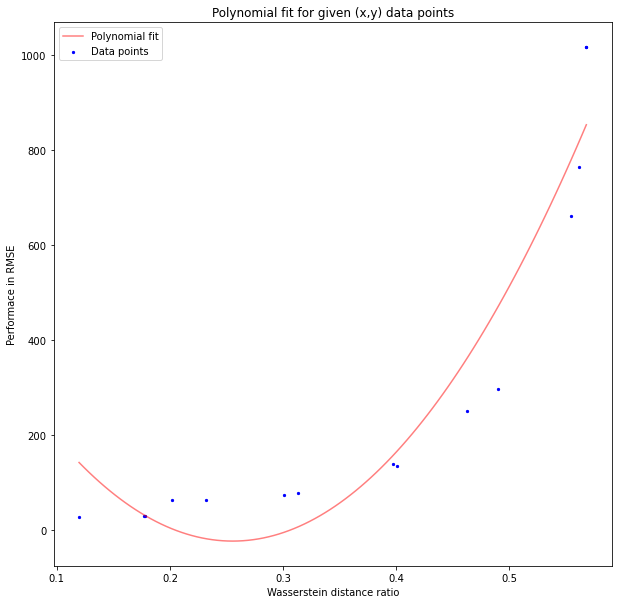

In [132]:
fit_polynomial_curve_to_data_and_visualize(df['WD ratio'].values, rmse_errors, 2, xlabel='Wasserstein distance ratio', ylabel='Performace in RMSE')

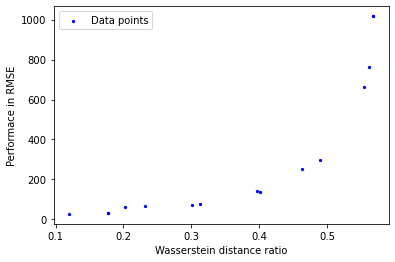

In [133]:
#Plotting
fig1 = plt.figure()
ax1 = fig1.subplots()
ax1.scatter(df['WD ratio'], rmse_errors, s = 5, color = 'b', label = 'Data points')
ax1.set_xlabel('Wasserstein distance ratio')
ax1.set_ylabel('Performace in RMSE')
ax1.legend()
plt.show()

#### Find MSE of each data point using CONFINE method

In [134]:
for i in range(num_clusters):
    print(f"cluster {i}- {len(kmeans.data[kmeans.data_preds == i])}")

cluster 0- 946
cluster 1- 398
cluster 2- 320
cluster 3- 621
cluster 4- 1105


In [135]:
num_neighbors = 320

In [136]:
y_train = y_train_lstm.flatten().numpy()

##### Get indices of the training points that have been assigned to respective cluster

In [137]:
cluster0 = (np.where(kmeans.labels_ == 0))
cluster1 = (np.where(kmeans.labels_ == 1))
cluster2 = (np.where(kmeans.labels_ == 2))
cluster3 = (np.where(kmeans.labels_ == 3))
cluster4 = (np.where(kmeans.labels_ == 4))

##### Get the difference between train preds and train gt values 

In [138]:
train_diff_df = pd.read_csv('Google_ErrorDistribution.csv', usecols=[2])
train_diff_df.head()

,diff
0,21.144577
1,18.875854
2,18.372643
3,17.953827
4,19.183685


##### Get training points (members) of each cluster 

In [139]:
training_diff = train_diff_df['diff']
training_diff = training_diff.values

In [140]:
type(training_diff)

numpy.ndarray

In [141]:
cluster0_errors = training_diff[cluster0[0]]
cluster1_errors = training_diff[cluster1[0]]
cluster2_errors = training_diff[cluster2[0]]
cluster3_errors = training_diff[cluster3[0]]
cluster4_errors = training_diff[cluster4[0]]

In [142]:
np.random.seed(21)
cluster2_neighbors = np.random.choice(cluster2_errors, num_neighbors, replace=False)
cluster3_neighbors = np.random.choice(cluster3_errors, num_neighbors, replace=False)

In [143]:
squared_error_2 = [n ** 2 for n in cluster2_neighbors]
squared_error_2 = np.array(squared_error_2)

In [144]:
squared_error_3 = [n ** 2 for n in cluster3_neighbors]
squared_error_3 = np.array(squared_error_3)

In [145]:
scaler = MinMaxScaler(feature_range=(0, 1))
se_norm_2 = scaler.fit_transform(squared_error_2.reshape(-1, 1))

In [146]:
scaler = MinMaxScaler(feature_range=(0, 1))
se_norm_3 = scaler.fit_transform(squared_error_3.reshape(-1, 1))

In [147]:
se_norm_2 = np.around(se_norm_2, 4)

In [148]:
se_norm_3 = np.around(se_norm_3, 4)

In [149]:
mse_2 = np.mean(se_norm_2)

In [150]:
mse_2 = np.round(mse_2, 4)
mse_2

0.0556

In [151]:
mse_3 = np.mean(se_norm_3)

In [152]:
mse_3 = np.round(mse_3, 4)
mse_3

0.0154

In [153]:
confine_mse = []

In [154]:
for i in df['Assigned cluster']:

    if i==2:
        confine_mse.append(mse_2) 
    elif i==3:
        confine_mse.append(mse_3)    


# confine_mse = [0.3188, 0.2606, 0.3188, 0.3188, 0.3188, 0.3188, 0.3188, 0.2606, 0.3188, 0.3188, 0.3188, 0.3188,
#                 0.3188, 0.3188, 0.3188, 0.3188, 0.3188, 0.3188, 0.3188, 0.3188]

In [155]:
len(confine_mse)

15

In [156]:
df['mse'] = confine_mse

In [157]:
df

,Test point,Test point mean,Assigned cluster,WD origin,Anderson_Darling_dist,CVM_dist,DTS_dist,Kolmogorov_Smirnov_dist,Kuiper_dist,Wasserstein distance,WD ratio,RMSE,MAPE,R2-score,mse
0,418,1.248297,2,1009.653857,8.639073,38.94,84.003728,1.00,1.00,404.644568,0.400776,135.042738,8.035833,-4.075193,0.0556
1,413,1.241669,2,1009.653857,8.639073,38.94,83.314381,1.00,1.00,400.730027,0.396898,140.194264,8.516297,-5.164708,0.0556
2,510,1.400148,2,1009.653857,8.639073,38.94,101.199733,1.00,1.00,494.301885,0.489576,298.348724,16.138417,-17.996479,0.0556
3,582,1.511167,2,1009.653857,8.639073,38.94,114.038728,1.00,1.00,559.893577,0.554540,662.061836,29.103729,-26.162855,0.0556
4,175,0.866829,2,1009.653857,8.639073,38.94,38.491770,1.00,1.00,179.362181,0.177647,29.738688,1.810659,-0.246442,0.0556
5,342,0.959476,2,1009.653857,8.558610,38.54,51.502797,0.98,0.98,234.025640,0.231788,64.586636,4.448203,0.611982,0.0556
6,141,0.767736,2,1009.653857,8.291315,37.26,27.748627,0.96,0.96,120.828255,0.119673,27.269175,1.621401,0.650558,0.0556
7,640,1.534182,2,1009.653857,8.639073,38.94,116.422902,1.00,1.00,573.487911,0.568004,1016.980088,38.886791,-97.124071,0.0556
8,640,1.534182,2,1009.653857,8.639073,38.94,116.422902,1.00,1.00,573.487911,0.568004,1016.980088,38.886791,-97.124071,0.0556
9,78,0.866276,2,1009.653857,8.639073,38.94,38.850559,1.00,1.00,178.954807,0.177244,30.328646,2.156502,0.250831,0.0556


In [158]:
df['staDRE'] = (2 - df['mse'] - df['WD ratio'] ) / 2

In [159]:
df_RE = df[['Test point', 'Assigned cluster', 'RMSE', 'MAPE', 'R2-score', 'WD origin', 'Wasserstein distance', 'WD ratio', 'mse', 'staDRE']]

In [160]:
df_RE

,Test point,Assigned cluster,RMSE,MAPE,R2-score,WD origin,Wasserstein distance,WD ratio,mse,staDRE
0,418,2,135.042738,8.035833,-4.075193,1009.653857,404.644568,0.400776,0.0556,0.771812
1,413,2,140.194264,8.516297,-5.164708,1009.653857,400.730027,0.396898,0.0556,0.773751
2,510,2,298.348724,16.138417,-17.996479,1009.653857,494.301885,0.489576,0.0556,0.727412
3,582,2,662.061836,29.103729,-26.162855,1009.653857,559.893577,0.554540,0.0556,0.694930
4,175,2,29.738688,1.810659,-0.246442,1009.653857,179.362181,0.177647,0.0556,0.883376
5,342,2,64.586636,4.448203,0.611982,1009.653857,234.025640,0.231788,0.0556,0.856306
6,141,2,27.269175,1.621401,0.650558,1009.653857,120.828255,0.119673,0.0556,0.912364
7,640,2,1016.980088,38.886791,-97.124071,1009.653857,573.487911,0.568004,0.0556,0.688198
8,640,2,1016.980088,38.886791,-97.124071,1009.653857,573.487911,0.568004,0.0556,0.688198
9,78,2,30.328646,2.156502,0.250831,1009.653857,178.954807,0.177244,0.0556,0.883578


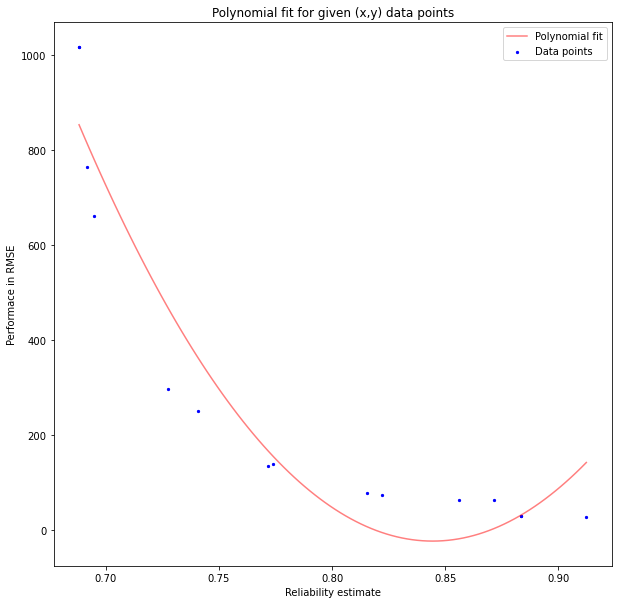

In [161]:
fit_polynomial_curve_to_data_and_visualize(df['staDRE'].values, df['RMSE'].values, 2, xlabel='Reliability estimate', ylabel='Performace in RMSE')

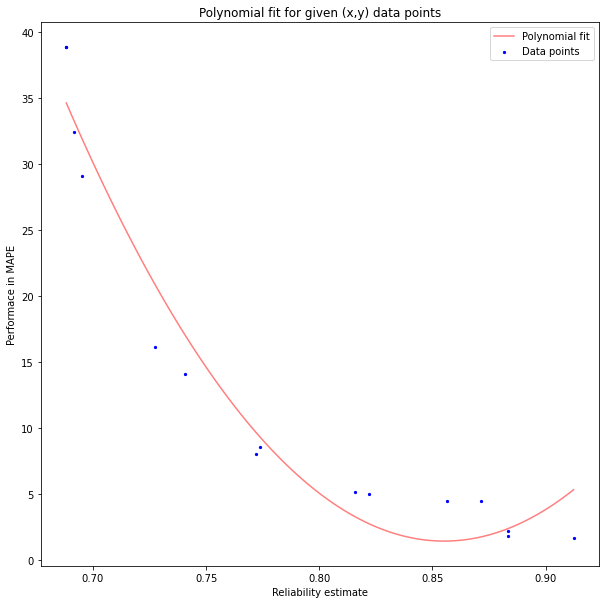

In [162]:
fit_polynomial_curve_to_data_and_visualize(df['staDRE'].values, df['MAPE'].values, 2, xlabel='Reliability estimate', ylabel='Performace in MAPE')

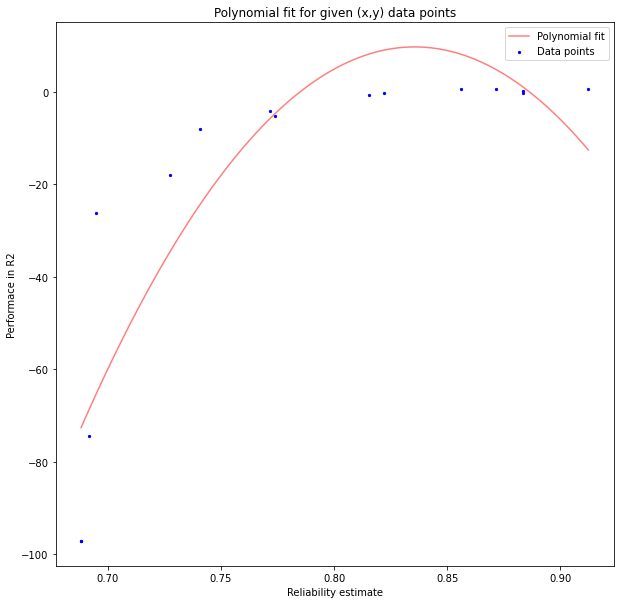

In [163]:
fit_polynomial_curve_to_data_and_visualize(df['staDRE'].values, df['R2-score'].values, 2, xlabel='Reliability estimate', ylabel='Performace in R2')

In [164]:
df_RE.to_csv('google_stadre_new.csv', index=False)

In [165]:
scaler = MinMaxScaler()

In [166]:
x = np.array(df_RE['staDRE'].values)
y = np.array(df_RE['RMSE'].values)
# ya = np.array(airtel['MAPE'].values)
# ya = np.array(airtel['R2-score'].values)

z = np.polyfit(x, y, 2)

fit = np.poly1d(z)

x_min = x.min()
x_max = x.max()

xp = np.linspace(x_min, x_max, 100)
yp = fit(xp)

In [167]:
fit

poly1d([ 35861.09482729, -60566.83612119,  25550.83667258])

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


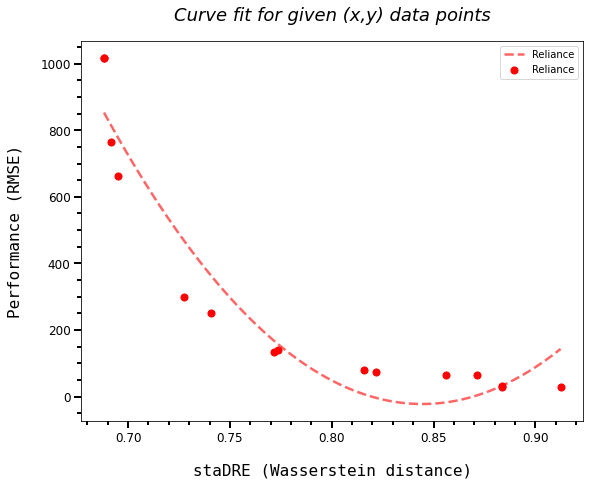

In [168]:
#Plotting RMSE-staDRE
fig1 = plt.figure(figsize=(9,7))
ax1 = fig1.subplots()
ax1.plot(xp, yp, 'r', linestyle='dashed', linewidth=2.5, alpha = 0.6, label = 'Reliance')
ax1.scatter(x, y, 50, 'r', "o", label = 'Reliance')
ax1.set_xlabel('staDRE (Wasserstein distance)', fontsize=16, family='monospace')
plt.xticks(fontsize=12)
ax1.tick_params(which='both', width=2, length=7)
ax1.tick_params(which='minor', length=4)
ax1.xaxis.labelpad = 18
ax1.set_ylabel('Performance (RMSE)', fontsize=16, family='monospace')
plt.yticks(fontsize=12)
ax1.yaxis.labelpad = 18
ax1.set_title('Curve fit for given (x,y) data points', fontsize=18, style='italic', pad=20)
plt.minorticks_on()
ax1.legend(loc='best')

plt.savefig('RMSE_vs._staDRE.eps', dpi=500)
plt.savefig('RMSE_vs._staDRE.jpg', dpi=500)
plt.savefig('RMSE_vs._staDRE.svg', dpi=500)
plt.show()

